In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import pickle as picklerick
import matplotlib.pyplot as plt
import time
import tqdm as notebook_tqdm



/home/aaronlaszlo/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
num_workers = 16
batch_size = 10

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.nn.functional.avg_pool2d(x, kernel_size=4, stride=2)),
])

In [5]:
train_data = datasets.MNIST(root='data', train=True,
                           download = True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, 
                          download = True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

(10, 1, 13, 13)


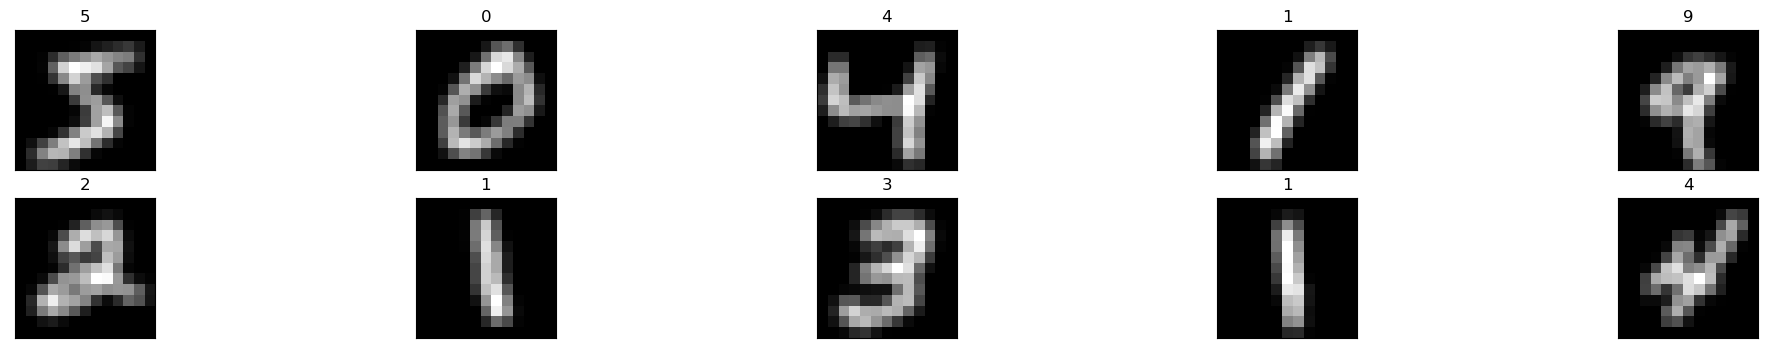

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

#obtain training image subbatch
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
print(images.shape)

#plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize= (25,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, int(batch_size/2), idx+1, xticks =[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap= 'gray')
    #print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))



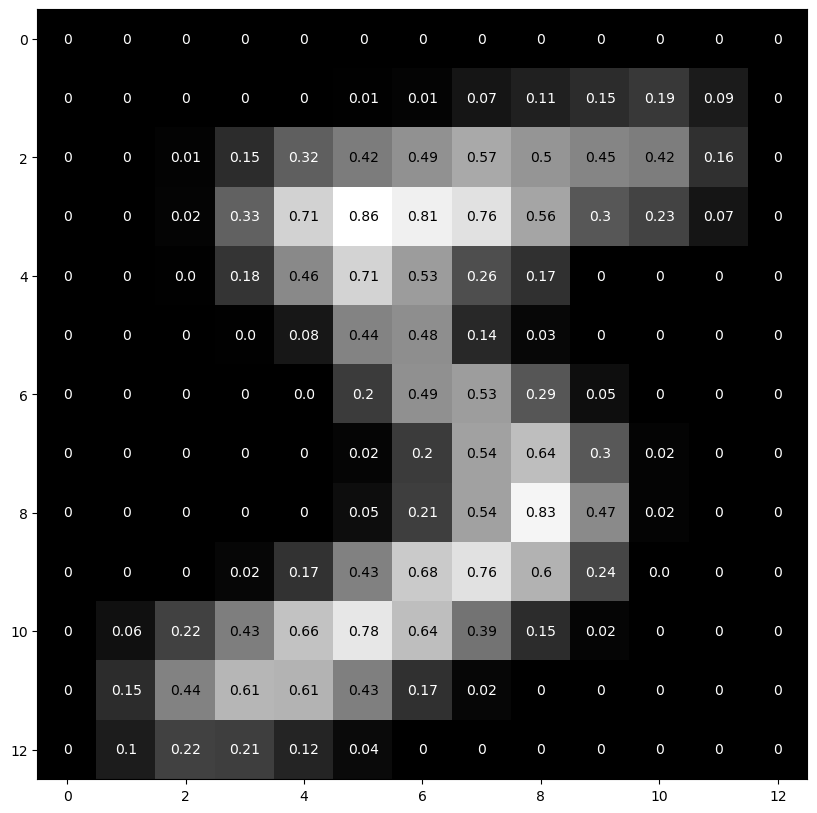

In [7]:
img = np.squeeze(images[0])

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.imshow(img, cmap= 'gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0 
        ax.annotate(str(val), xy=(y,x),
                   horizontalalignment='center',
                   verticalalignment='center',
                   color='white' if img[x][y]<thresh else 'black')

In [8]:
import torch.nn as nn 
import torch.nn.functional as F
from torchsummary import summary

In [9]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        #linear layer 13*13 input into 16 nodes
        self.fc1 = nn.Linear(13 * 13, 16)
        
        #linear layer (n_hidden -> 10)
        self.fc2 = nn.Linear(16, 10)
        
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 13 * 13)
        #add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        
        x= self.fc2(x)
        
        return x
    
# initialize the Neural Network
model = NeuralNet()
print(model)

if train_on_gpu:
    model.cuda()
summary(model, input_size=(1, 13, 13))



NeuralNet(
  (fc1): Linear(in_features=169, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]           2,720
            Linear-2                   [-1, 10]             170
Total params: 2,890
Trainable params: 2,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [10]:
# specify loss and optimaization functions

#specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimization
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [11]:
# number of epochs to train the model
n_epochs = 5 #suggest training between 20-50 epochs

#set model to the training mode
model.train()

for epoch in range(n_epochs):
    #monitor training loss
    train_loss = 0.0
    
    ##################
    # training model #
    ##################
    
    for data, target in train_loader:
        #clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.cuda())
        
        # calculate the loss
        loss = criterion(output, target.cuda())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    #print training statistics 
    #calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
    epoch+1,
    train_loss
    ))

Epoch: 1 	Training Loss: 0.991109
Epoch: 2 	Training Loss: 0.410534
Epoch: 3 	Training Loss: 0.351189
Epoch: 4 	Training Loss: 0.324633
Epoch: 5 	Training Loss: 0.308197


In [12]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

#set model to evaluation mode
model.eval()

for data, target in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.cuda())
        #calculate the loss 
    loss = criterion(output.cuda(), target.cuda())
        #update test loss 
    test_loss += loss.item()*data.size(0)
        #convert output probabilities to predicted class
    _, pred = torch.max(output.cuda(), 1)
        #compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred).cuda()))
        #calculate test accuracy for each object class
    for i in range(batch_size):
        try:
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1 
        except IndexError:
            break
                    
    #calculate and print avg test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else: 
            print('Test Accuracy of %5s: N/A (no training examples)' % (class_correct[i]))
            
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
                

Test Loss: 0.000471

Test Accuracy of 0: 100% ( 1/ 1)
Test Accuracy of 1: 100% ( 2/ 2)
Test Accuracy of 2: 100% ( 1/ 1)
Test Accuracy of   0.0: N/A (no training examples)
Test Accuracy of 4: 100% ( 2/ 2)
Test Accuracy of 5:  0% ( 0/ 1)
Test Accuracy of   0.0: N/A (no training examples)
Test Accuracy of 7: 100% ( 1/ 1)
Test Accuracy of   0.0: N/A (no training examples)
Test Accuracy of 9: 100% ( 2/ 2)

Test Accuracy (Overall): 90% ( 9/10)
Test Loss: 0.000047

Test Accuracy of 0: 100% ( 3/ 3)
Test Accuracy of 1: 100% ( 3/ 3)
Test Accuracy of 2: 100% ( 1/ 1)
Test Accuracy of 3: 100% ( 1/ 1)
Test Accuracy of 4: 100% ( 3/ 3)
Test Accuracy of 5: 50% ( 1/ 2)
Test Accuracy of 6: 100% ( 1/ 1)
Test Accuracy of 7: 100% ( 2/ 2)
Test Accuracy of   0.0: N/A (no training examples)
Test Accuracy of 9: 100% ( 4/ 4)

Test Accuracy (Overall): 95% (19/20)
Test Loss: 0.000067

Test Accuracy of 0: 100% ( 5/ 5)
Test Accuracy of 1: 100% ( 4/ 4)
Test Accuracy of 2: 100% ( 1/ 1)
Test Accuracy of 3: 100% ( 1/ 1)

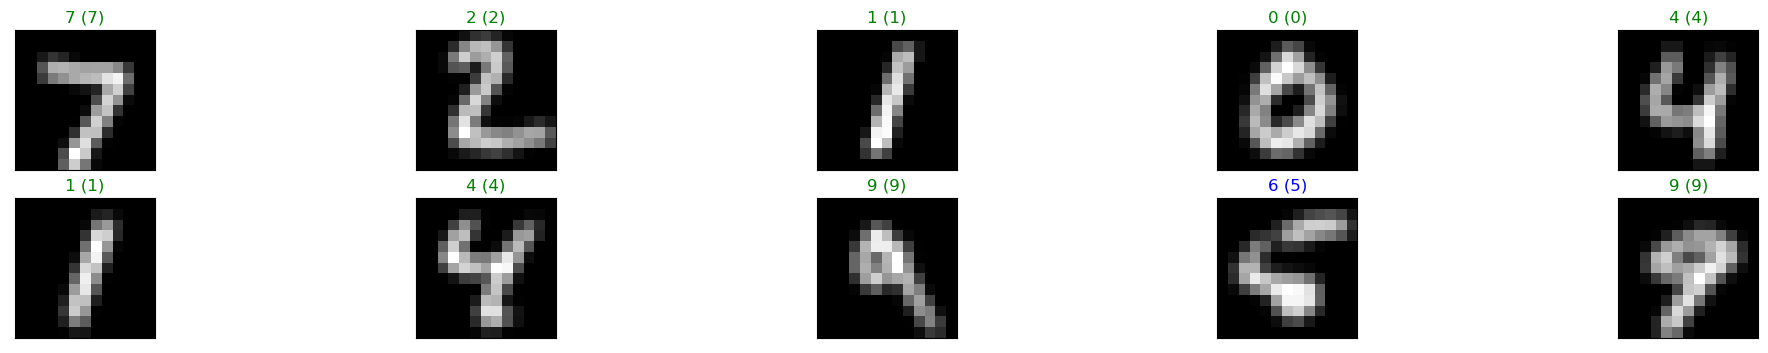

In [13]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
output = model(images.cuda())
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, int(batch_size/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "blue"))